## Get data

In [80]:
#imports
from astroquery.gaia import Gaia
import pandas as pd 
import seaborn as sns
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy
import statsmodels.api as sm

In [2]:
#gaia query

job = Gaia.launch_job_async("SELECT ALL gaia_source.source_id,gaia_source.ra,gaia_source.dec,\
gaia_source.pmra,gaia_source.pmdec,gaia_source.phot_bp_mean_mag FROM gaiadr2.gaia_source WHERE CONTAINS\
(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',229.226,7.002,0.3))=1")  
                           # AND  \(gaiadr2.gaia_source.phot_bp_mean_mag<=20)")

Query finished.


In [3]:
#get resulting gaia datatable
r = job.get_results() #print(r['ra','dec'])
df_gaia = r.to_pandas()

In [4]:
#read apt datatable
filename = "pi26133_001.csv"
df_apt_ = pd.read_csv(filename) 
df_apt = df_apt_[['CentroidRA', 'CentroidDec','Magnitude', 'MagUncertainty']]

## Plots

Text(0.5,1,'Position match')

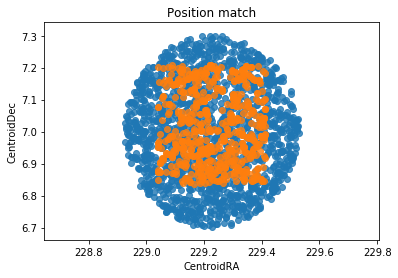

In [5]:
#check ra and dec matching
sns.regplot('ra', 'dec', data=df_gaia, fit_reg = False)
sns.regplot('CentroidRA', 'CentroidDec', data=df_apt, fit_reg = False).set_title("Position match")

In [6]:
maxdiff = 0.001
df_gaia['mag_mod'] = 0.8783*df_gaia.phot_bp_mean_mag-6.1212

querystr = "diff<" + str(maxdiff)
df = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag','pmra','pmdec',\
                           'CentroidRA','CentroidDec','Magnitude','diff'])
dist = scipy.spatial.distance.cdist(df_apt[['CentroidRA', 'CentroidDec']], df_gaia[['ra', 'dec']]) 
dist_mag = scipy.spatial.distance.cdist(df_apt[['Magnitude']], df_gaia[['mag_mod']]) 
min_dist = np.argmin(dist, axis=1) 

m = 0
while m < len(df_apt): #apt (6)
    n = min_dist[m]    #gaia (8)
    df = df.append({'ra': df_gaia['ra'][n], 'dec': df_gaia['dec'][n],\
                    'phot_bp_mean_mag': df_gaia['phot_bp_mean_mag'][n],\
                    'pmra': df_gaia['pmra'][n], 'pmdec': df_gaia['pmdec'][n],\
                    'CentroidRA': df_apt['CentroidRA'][m],'CentroidDec': df_apt['CentroidDec'][m],\
                    'Magnitude': df_apt['Magnitude'][m],\
                    'diff': dist[m][n],\
                    'dist_mag': dist_mag[m][n]
                   }, ignore_index=True)
    m+=1


df = df.query(querystr)
df = df.sort_values('diff').drop_duplicates('ra')
df = df.sort_values('diff').drop_duplicates('CentroidRA')
#df= df.reset_index(drop=True)

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of difference in match')

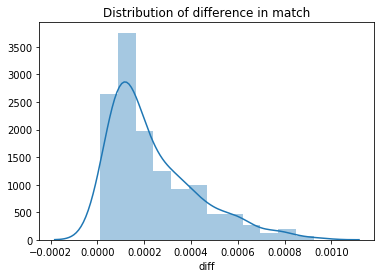

In [7]:
sns.distplot(df['diff']).set_title('Distribution of difference in match')

In [10]:
#new vars
df['Δra'] = df.apply(lambda row: row.ra - row.CentroidRA, axis = 1) 
df['Δdec'] = df.apply(lambda row: row.dec - row.CentroidDec, axis = 1) 
df['Δmag'] = df.apply(lambda row: row.Magnitude - row.phot_bp_mean_mag, axis = 1) 

#subset
df_filtered = df.query('diff<0.0002')

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'dec vs. Δdec')

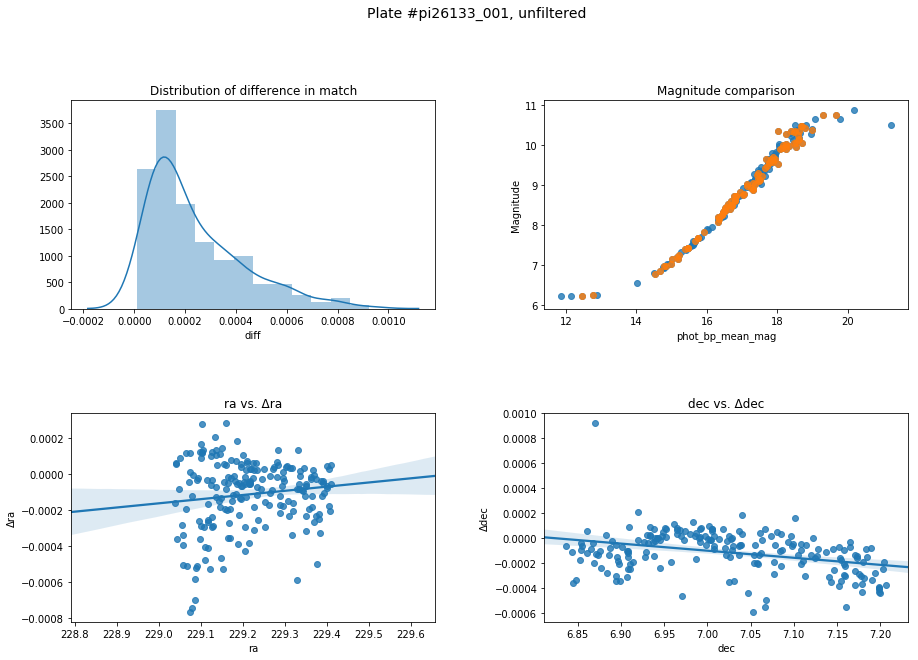

In [11]:
fig = plt.figure(figsize=(15,10))
title = fig.suptitle("Plate #pi26133_001, unfiltered", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace=0.5)

ax1 = fig.add_subplot(2,2,1)
sns.distplot(df['diff']).set_title('Distribution of difference in match')
ax2 = fig.add_subplot(2,2,2)
sns.regplot('phot_bp_mean_mag','Magnitude',data=df, fit_reg = False).set_title('Magnitude comparison')
sns.regplot('phot_bp_mean_mag','Magnitude',data=df_filtered, fit_reg = False).set_title('Magnitude comparison')
ax3 = fig.add_subplot(2,2,3)
sns.regplot('ra','Δra',data=df).set_title('ra vs. Δra')
ax4 = fig.add_subplot(2,2,4)
sns.regplot('dec','Δdec',data=df).set_title('dec vs. Δdec')

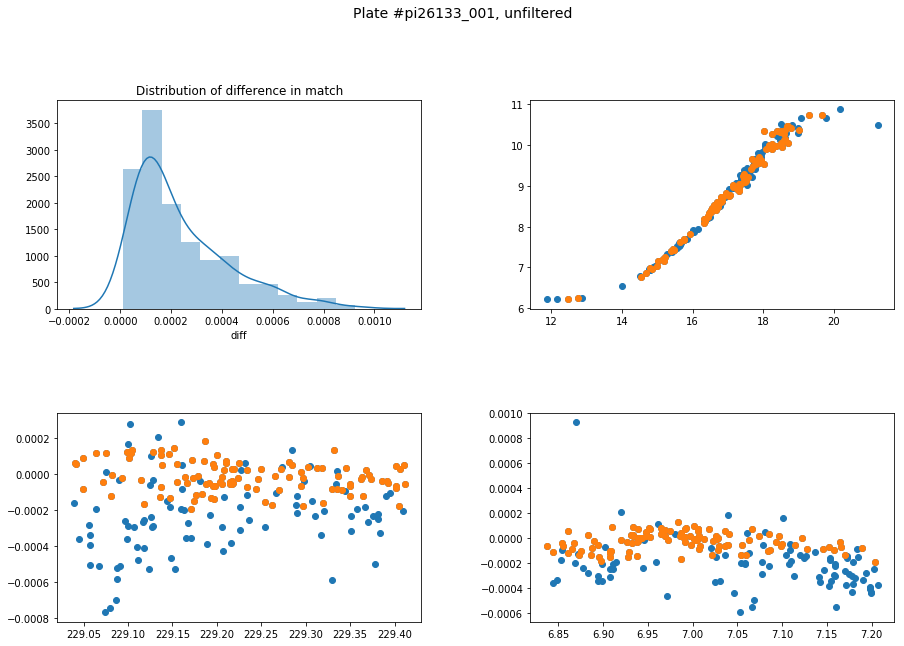

In [185]:
def p_scatter(df1, df2, x, y, xlim =[0,0] , ylim=[0,0]):
    '''
    This function uses matplotlib.pyplot to graph two functions and fix axis (calculated if not given).
    df2 should be the smaller subset.
    '''
    axes = plt.gca()
    plt.scatter(df1[x], df1[y]) 
    plt.scatter(df2[x], df2[y]) 
    if xlim == [0,0]:
        xlim = [df[x].min()-(df[x].max()-df[x].min())*0.05, df[x].max() + (df[x].max()-df[x].min())*0.05]
    if ylim == [0,0]:
        ylim = [df[y].min()-(df[y].max()-df[y].min())*0.05, df[y].max() + (df[y].max()-df[y].min())*0.05]
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)

    
fig = plt.figure(figsize=(15,10))
title = fig.suptitle("Plate #pi26133_001, unfiltered", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace=0.5)

ax1 = fig.add_subplot(2,2,1)
sns.distplot(df['diff']).set_title('Distribution of difference in match')
ax2 = fig.add_subplot(2,2,2)
p_scatter(df, df_filtered, 'phot_bp_mean_mag', 'Magnitude')
ax3 = fig.add_subplot(2,2,3)
#sns.regplot('ra','Δra',data=df).set_title('ra vs. Δra')
p_scatter(df, df_filtered, 'ra', 'Δra')
ax4 = fig.add_subplot(2,2,4)
p_scatter(df, df_filtered, 'dec', 'Δdec')

Text(0,0.5,'Δdec')

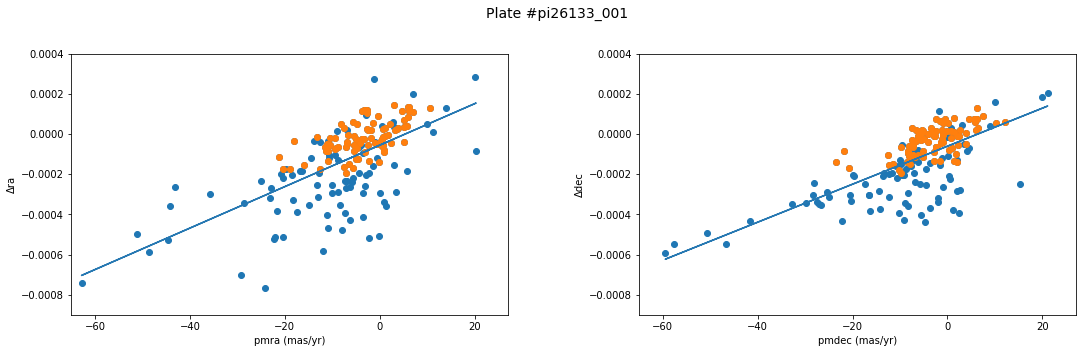

In [142]:
#graphing proper motion

df_na = df.dropna().reset_index(drop=True)#for regression
fig = plt.figure(figsize=(18,5))#graph size
title = fig.suptitle("Plate #pi26133_001", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace=0.5)

ax1 = fig.add_subplot(121)#graph1
X = df_na["pmra"] #regression model
y = df_na["Δra"] 
X = sm.add_constant(X)
model = sm.OLS(y, X).fit() 
pred = df_na["pmra"]*model.params['pmra']+model.params['const']
plt.scatter(df["pmra"], df["Δra"]) #points = 
plt.scatter(df_filtered["pmra"], df_filtered["Δra"])
plt.plot(df_na["pmra"],pred,'#2678b2')#regression
axes = plt.gca()#axis names
axes.set_xlim([-65,27])
axes.set_ylim([-0.0009,0.0004])
plt.xlabel("pmra (mas/yr)")
plt.ylabel("Δra")

ax1 = fig.add_subplot(122)#graph2
X = df_na["pmdec"] #regression model
y = df_na["Δdec"] 
X = sm.add_constant(X)
model = sm.OLS(y, X).fit() 
pred = df_na["pmdec"]*model.params['pmdec']+model.params['const']
plt.scatter(df["pmdec"], df["Δdec"]) #points = 
plt.scatter(df_filtered["pmdec"], df_filtered["Δdec"])
plt.plot(df_na["pmdec"],pred,'#2678b2')#regression
axes = plt.gca()
axes.set_xlim([-65,27])
axes.set_ylim([-0.0009,0.0004])
plt.xlabel("pmdec (mas/yr)")
plt.ylabel("Δdec")

### Regression

In [111]:
df_filtered_ = df_filtered.query('phot_bp_mean_mag>14').dropna()

In [125]:
X = df_filtered_["phot_bp_mean_mag"] ## X usually means our input variables (or independent variables)
y = df_filtered_["Magnitude"] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
#predictions = model.predict(X)

# Print out the statistics
model.summary()
#print(model.params)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Magnitude   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     6582.
Date:                Thu, 26 Sep 2019   Prob (F-statistic):           4.37e-80
Time:                        11:34:57   Log-Likelihood:                 58.676
No. Observations:                  84   AIC:                            -113.4
Df Residuals:                      82   BIC:                            -108.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -6.1212      0.186    -32.894      0.000      -6.491      -5.751
phot_bp_mean_mag     0.8783      0.011     81.128      0.000       0.857       0.900
==============================================================================
Omnibus:                        5.950   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                8.921
Skew:                           0.139   Prob(JB):                       0.0116
Kurtosis:                       4.572   Cond. No.                         242.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Match by position and distance

In [26]:
df_gaia = r.to_pandas().dropna().query('phot_bp_mean_mag>14').reset_index(drop=True)
df_apt_ = pd.read_csv(filename).dropna().reset_index(drop=True)
df_apt = df_apt_[['CentroidRA', 'CentroidDec','Magnitude', 'MagUncertainty']]

In [27]:
df_gaia['mag_mod'] = 0.8783*df_gaia.phot_bp_mean_mag-6.1212

In [44]:
maxdiff = 1 #0.001
querystr = "diff<" + str(maxdiff)
df = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag','pmra','pmdec',\
                           'CentroidRA','CentroidDec','Magnitude','diff'])
dist = scipy.spatial.distance.cdist(df_apt[['CentroidRA', 'CentroidDec']], df_gaia[['ra', 'dec']]) 
dist_mag = scipy.spatial.distance.cdist(df_apt[['Magnitude']], df_gaia[['mag_mod']]) 

tdist = dist*1+dist_mag*0.0

min_dist = np.argmin(tdist, axis=1) 

m = 0
while m < len(df_apt): 
    n = min_dist[m] 
    df = df.append({'ra': df_gaia['ra'][n], 'dec': df_gaia['dec'][n],\
                    'phot_bp_mean_mag': df_gaia['phot_bp_mean_mag'][n],\
                    'mag_mod': df_gaia['mag_mod'][n],\
                    'pmra': df_gaia['pmra'][n], 'pmdec': df_gaia['pmdec'][n],\
                    'CentroidRA': df_apt['CentroidRA'][m],'CentroidDec': df_apt['CentroidDec'][m],\
                    'Magnitude': df_apt['Magnitude'][m],\
                    'diff': dist[m][n],\
                    'dist_mag': dist_mag[m][n]
                   }, ignore_index=True)
    m+=1


df = df.query(querystr)
df = df.sort_values('diff').drop_duplicates('ra')
df = df.sort_values('diff').drop_duplicates('CentroidRA')
#df= df.reset_index(drop=True)

In [45]:
#new vars
df['Δra'] = df.apply(lambda row: row.ra - row.CentroidRA, axis = 1) 
df['Δdec'] = df.apply(lambda row: row.dec - row.CentroidDec, axis = 1) 
df['Δmag'] = df.apply(lambda row: row.Magnitude - row.phot_bp_mean_mag, axis = 1) 

#subset
df_filtered = df.query('diff<0.0002')

(-0.0003, 0.0003)

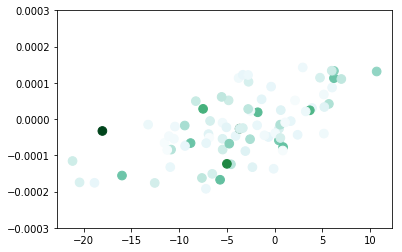

In [79]:
points = plt.scatter(df_filtered["pmra"], df_filtered["Δra"],
                     c=df_filtered["dist_mag"], s=75, cmap="BuGn")
axes = plt.gca()
axes.set_ylim([-0.0003,0.0003])

#sns.regplot('pmra','Δra',c = 'dist_mag',data=df_filtered).set_title('pmra')

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'dec vs. Δdec')

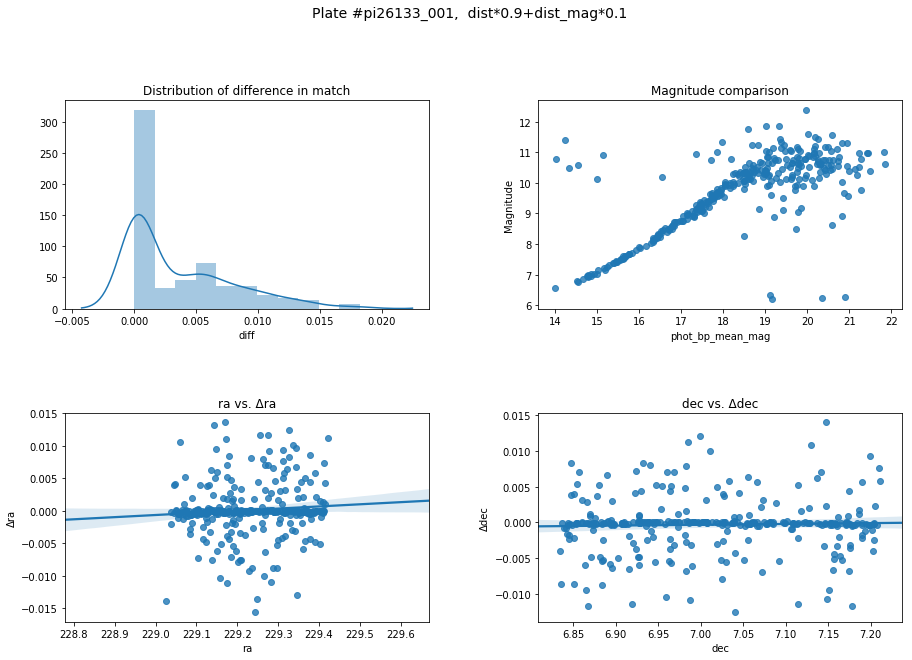

In [37]:
fig = plt.figure(figsize=(15,10))
title = fig.suptitle("Plate #pi26133_001,  dist*0.9+dist_mag*0.1", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace=0.5)

ax1 = fig.add_subplot(2,2,1)
sns.distplot(df['diff']).set_title('Distribution of difference in match')
ax2 = fig.add_subplot(2,2,2)
sns.regplot('phot_bp_mean_mag','Magnitude',data=df, fit_reg = False).set_title('Magnitude comparison')
ax3 = fig.add_subplot(2,2,3)
sns.regplot('ra','Δra',data=df).set_title('ra vs. Δra')
ax4 = fig.add_subplot(2,2,4)
sns.regplot('dec','Δdec',data=df).set_title('dec vs. Δdec')

Text(0.5,1,'pmdec')

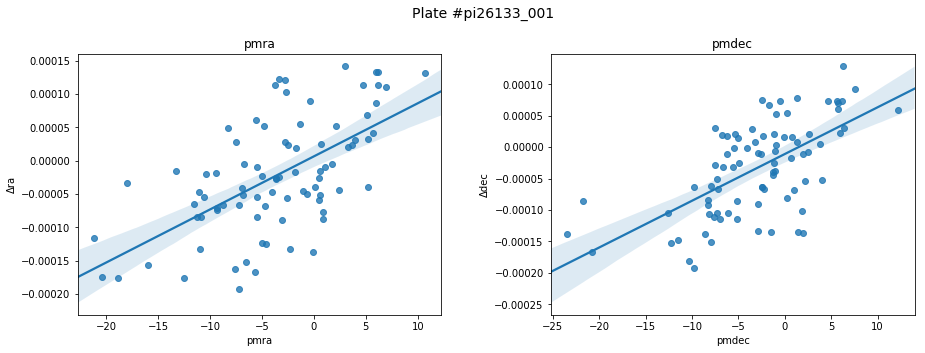

In [39]:
fig = plt.figure(figsize=(15,5))
title = fig.suptitle("Plate #pi26133_001", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace=0.5)

ax1 = fig.add_subplot(1,2,1)
sns.regplot('pmra','Δra',data=df_filtered).set_title('pmra')
ax2 = fig.add_subplot(1,2,2)
sns.regplot('pmdec','Δdec',data=df_filtered).set_title('pmdec')